In this tutorial we take a look at subsetting the model data along a transect (a custom straight line) and creating some bespoke diagnostics along it. We look at:

    1. Creating a TRANSECT object, defined between two points.
    2. Plotting data along a transect.
    3. Calculating flow normal to the transect

## Create a transect subset of the example dataset

Load packages and define some file paths

In [1]:
import coast
import xarray as xr
import matplotlib.pyplot as plt

fn_nemo_dat_t = './example_files/nemo_data_T_grid.nc'
fn_nemo_dat_u = './example_files/nemo_data_U_grid.nc'
fn_nemo_dat_v = './example_files/nemo_data_V_grid.nc'
fn_nemo_dom = './example_files/COAsT_example_NEMO_domain.nc'

Load data variables that are on the NEMO t-grid

In [2]:
nemo_t = coast.NEMO( fn_data = fn_nemo_dat_t, fn_domain = fn_nemo_dom, grid_ref = 't-grid', chunks={} )

Now create a transect between the points (54 N 15 W) and (56 N, 12 W) using the `coast.Transect_t` object. This needs to be passed the corresponding NEMO object and transect end points. The model points closest to these coordinates will be selected as the transect end points.

In [3]:
tran_t = coast.Transect_t( nemo_t, (54,-15), (56,-12) )
tran_t.data

<xarray.Dataset>
Dimensions:      (r_dim: 58, t_dim: 7, z_dim: 51)
Coordinates:
    time         (t_dim) datetime64[ns] 2010-01-01T12:00:00 ... 2010-01-07T12...
    longitude    (r_dim) float32 -15.0 -15.0 -14.888672 ... -12.111328 -12.0
    latitude     (r_dim) float32 54.000977 54.067383 ... 56.000977 56.000977
    depth_0      (z_dim, r_dim) float32 0.49951172 0.49951172 ... 2735.997
Dimensions without coordinates: r_dim, t_dim, z_dim
Data variables:
    e3t_25h      (t_dim, z_dim, r_dim) float32 dask.array<chunksize=(7, 51, 58), meta=np.ndarray>
    temperature  (t_dim, z_dim, r_dim) float32 dask.array<chunksize=(7, 51, 58), meta=np.ndarray>
    salinity     (t_dim, z_dim, r_dim) float32 dask.array<chunksize=(7, 51, 58), meta=np.ndarray>
    ssh          (t_dim, r_dim) float32 dask.array<chunksize=(7, 58), meta=np.ndarray>
    mld          (t_dim, r_dim) float32 dask.array<chunksize=(7, 58), meta=np.ndarray>
    bathymetry   (r_dim) float32 ...
    e1           (r_dim) float32 7262.1484 7250.5117 ... 6908.8594 6908.8594
    e2           (r_dim) float32 7413.633 7413.633 ... 7413.633 7413.633
    e3_0         (z_dim, r_dim) float32 ...
Attributes:
    name:         AMM7_1d_20100101_20100131_25hourm_grid_T
    description:  ocean T grid variables, 25h meaned
    title:        ocean T grid variables, 25h meaned
    Conventions:  CF-1.6
    timeStamp:    2019-Dec-27 04:41:46 GMT
    uuid:         4e7ff0ad-48d8-4409-b697-af4b0fde75cf

where `r_dim` is the dimension along the transect. It is simple to plot a scalar such as temperature along the transect:

/Users/Dave/anaconda3/envs/workshop_env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


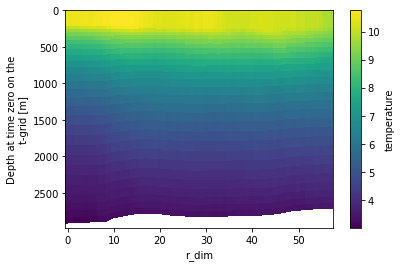

In [4]:
temp_mean = tran_t.data.temperature.mean(dim='t_dim')
temp_mean.plot.pcolormesh(y='depth_0', yincrease=False )

## Flow across the transect
With NEMO’s staggared grid, the first step is to define the transect on the f-grid so that the velocity components are between f-points. We do not need any model data on the f-grid, just the grid information, so create a nemo f-grid object

In [5]:
nemo_f = coast.NEMO( fn_domain = fn_nemo_dom, grid_ref='f-grid', chunks={} )

and a transect on the f-grid

In [6]:
tran_f = coast.Transect_f( nemo_f, (54,-15), (56,-12) )
tran_f.data

<xarray.Dataset>
Dimensions:     (r_dim: 58, z_dim: 51)
Coordinates:
    longitude   (r_dim) float32 -15.055664 -15.055664 ... -12.166992 -12.055664
    latitude    (r_dim) float32 53.967773 54.03418 ... 55.967773 55.967773
    depth_0     (z_dim, r_dim) float32 0.49951172 0.49951172 ... 2739.0999
Dimensions without coordinates: r_dim, z_dim
Data variables:
    bathymetry  (r_dim) float32 ...
    e1          (r_dim) float32 7267.963 7256.332 ... 6914.8184 6914.8184
    e2          (r_dim) float32 7413.633 7413.633 7413.633 ... 7413.633 7413.633
    e3_0        (z_dim, r_dim) float32 ...

We also need the i- and j-components of velocity so (lazy) load the model data on the u- and v-grid grids

In [7]:
nemo_u = coast.NEMO( fn_data = fn_nemo_dat_u, fn_domain = fn_nemo_dom, grid_ref='u-grid', chunks={} )
nemo_v = coast.NEMO( fn_data = fn_nemo_dat_v, fn_domain = fn_nemo_dom, grid_ref='v-grid', chunks={} )

Now we can calculate the flow across the transect with the method

In [8]:
tran_f.calc_flow_across_transect(nemo_u,nemo_v)

The flow across the transect is stored in a new dataset where the variables are all defined at the points between f-points.

In [9]:
tran_f.data_cross_tran_flow

<xarray.Dataset>
Dimensions:            (r_dim: 57, t_dim: 7, z_dim: 51)
Coordinates:
    time               (t_dim) datetime64[ns] 2010-01-02 ... 2010-01-08
    depth_0            (z_dim, r_dim) float64 0.4995 0.4995 ... 2.739e+03
    latitude           (r_dim) float64 54.0 54.03 54.07 ... 55.9 55.93 55.97
    longitude          (r_dim) float64 -15.06 -15.0 -14.94 ... -12.17 -12.11
Dimensions without coordinates: r_dim, t_dim, z_dim
Data variables:
    normal_velocities  (t_dim, z_dim, r_dim) float64 0.05566 -0.07031 ... nan
    normal_transports  (t_dim, r_dim) float64 1.569 -1.09 ... 1.004 0.04741
    e1                 (r_dim) float64 7.262e+03 7.256e+03 ... 6.915e+03
    e2                 (r_dim) float64 7.414e+03 7.414e+03 ... 7.414e+03
    e3_0               (z_dim, r_dim) float64 1.0 1.0 1.0 ... 48.72 48.65 48.6

For example, to plot the time averaged velocity across the transect, we can plot the ‘normal_velocities’ variable

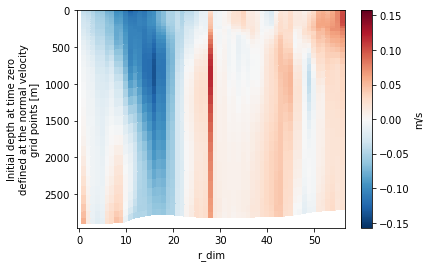

In [10]:
cross_velocity_mean = tran_f.data_cross_tran_flow.normal_velocities.mean(dim='t_dim')
cross_velocity_mean.rolling(r_dim=2).mean().plot.pcolormesh(yincrease=False,y='depth_0',cbar_kwargs={'label': 'm/s'})

or the volume transport across the transect, we can plot the ‘normal_transports’ variable

Text(0, 0.5, 'Sv')

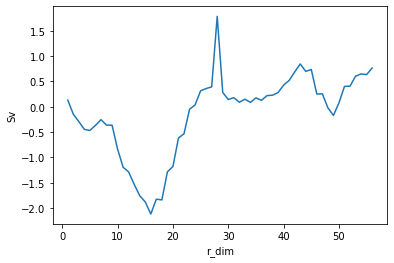

In [11]:
cross_transport_mean = tran_f.data_cross_tran_flow.normal_transports.mean(dim='t_dim')
cross_transport_mean.rolling(r_dim=2).mean().plot()
plt.ylabel('Sv')